# 构建网络模型

Model: "VocSegClassify"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 160, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 120, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 120, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 120, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 60, 128)    

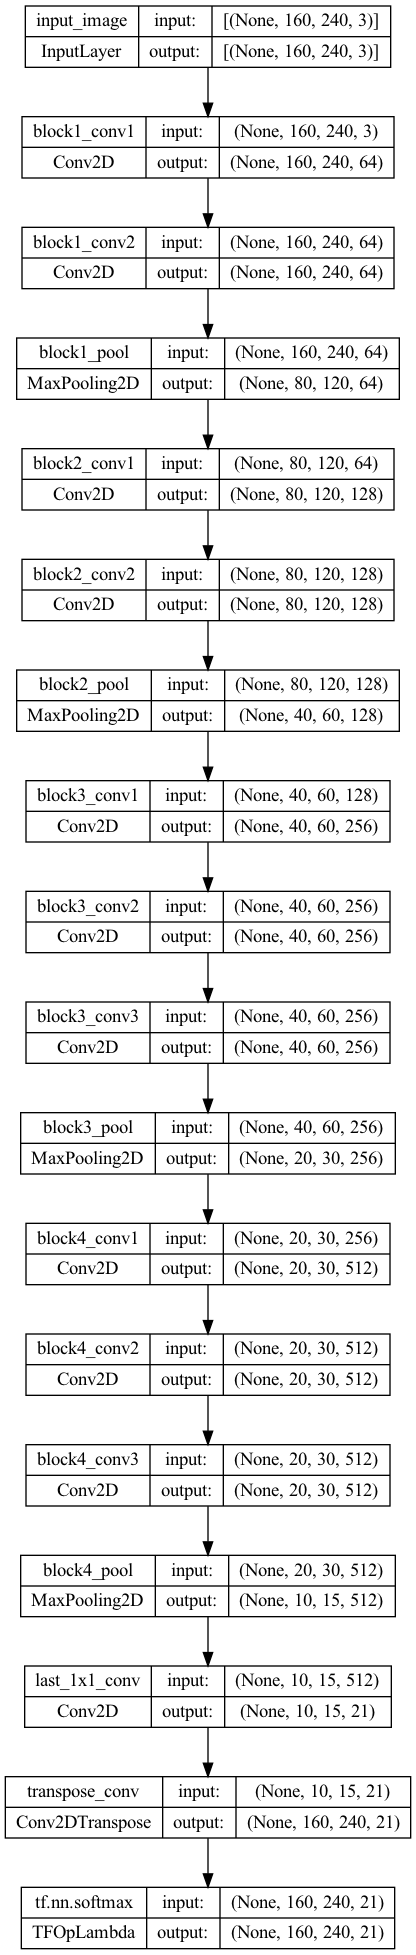

In [2]:
from voc_seg_classify import VocSegClassifyModel
from keras.utils import plot_model

m = VocSegClassifyModel(class_count=21).build_net()
m.summary()
plot_model(m, show_shapes=True)


# 预处理数据集

In [6]:
from datasets import VocDatasets
from voc_seg_classify import VocDataGenerator, VocSegClassifyModel
import matplotlib.pyplot as plt

ds=VocDatasets()
gen=VocDataGenerator(batch_size=32, ds=ds, force_rebuild=True)
print(f"case counts {len(gen.images)}")

pre process data...
pre process done.
case counts 2694


# 训练网络

In [ ]:
import tensorflow as tf


from datasets import VocDatasets
from voc_seg_classify import VocDataGenerator, VocSegClassifyModel
import matplotlib.pyplot as plt

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from voc_seg_classify import VocSegTrainer
# ! rm -rf log/*

trainer = VocSegTrainer()
trainer.train(epoch=20, batch_size=32, load_model=True)
trainer.voc_seg_model.save_model()

loading train data...
prepare_datasets done.
Epoch 1/20
26/85 [========>.....................] - ETA: 5:35 - loss: 0.4513

# 预测和展示效果

1/1 [==============================] - 0s 104ms/step


2023-01-31 00:43:49.196053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


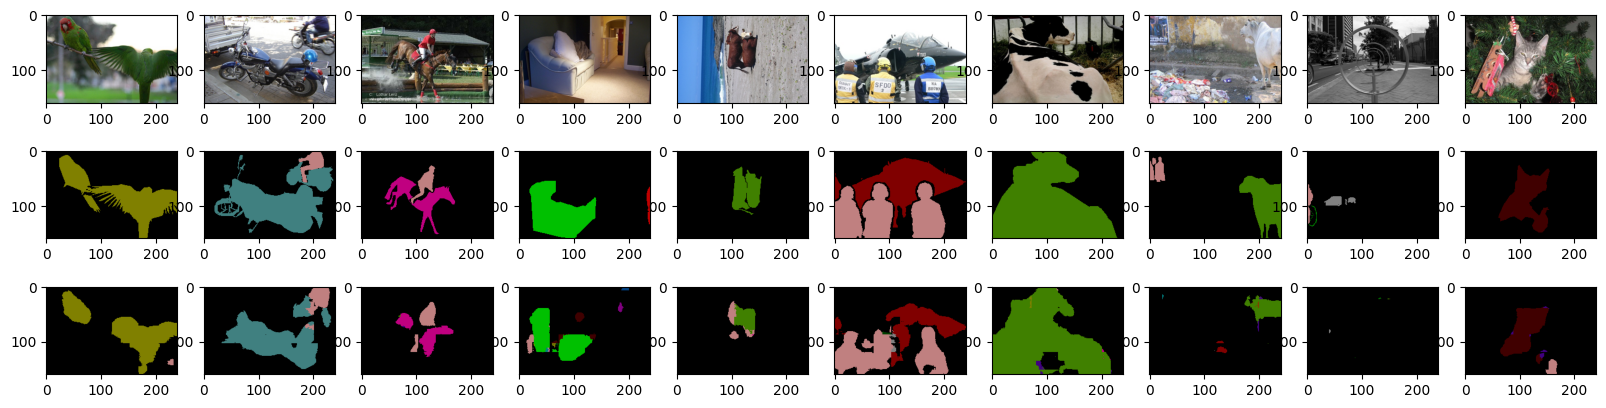

In [11]:
try:
    import tensorflow as tf
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from datasets import VocDatasets
from voc_seg_classify import VocDataGenerator, VocSegClassifyModel
import matplotlib.pyplot as plt

ds=VocDatasets()
m = VocSegClassifyModel(ds.class_count())
m.load_model()
show_pic_count=10
gen = VocDataGenerator(show_pic_count, ds)

inputs, labels = gen[2]
outputs=m.predict(inputs)

plt.figure(figsize=(20, 5))
for i, img in enumerate(inputs):
    plt.subplot(3, show_pic_count, i + 1)
    plt.imshow(inputs[i])
    label=labels[i]
    seg_img = ds.convert_label_to_seg_image(label)
    plt.subplot(3, show_pic_count, i + show_pic_count + 1)
    plt.imshow(seg_img)
    output = outputs[i]
    seg_img = ds.convert_label_to_seg_image(output)
    plt.subplot(3, show_pic_count, i + 2 * show_pic_count + 1)
    plt.imshow(seg_img)
plt.show()

# 测试其他个人照片

1/1 [==============================] - 0s 88ms/step


2023-01-31 00:42:46.375713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


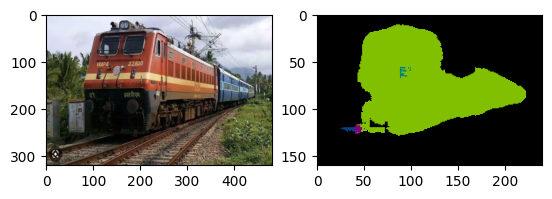

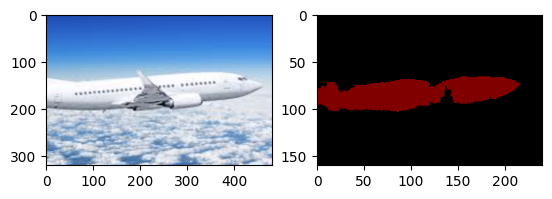

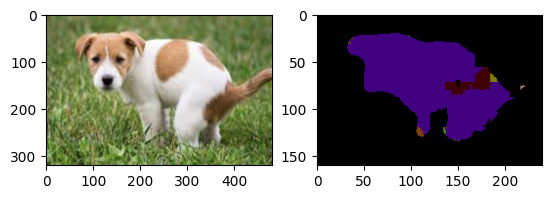

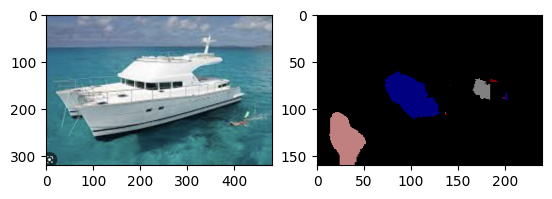

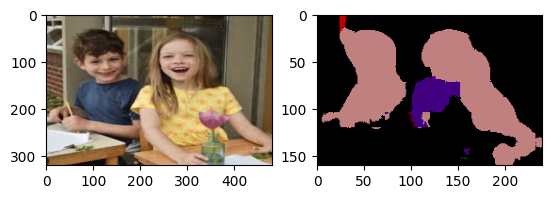

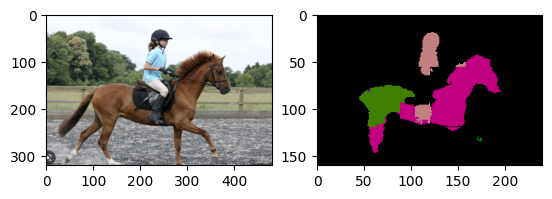

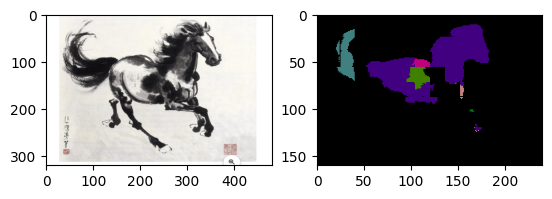

In [9]:
from datasets import VocDatasets
from voc_seg_classify import VocDataGenerator, VocSegClassifyModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

ds=VocDatasets()
m = VocSegClassifyModel(ds.class_count())
m.load_model()

img_path_list=[
    "data/train.png",
    "data/airplane.png",
    "data/dog.png",
    "data/boat.png",
    "data/home.png",
    "data/riding.png",
    "data/horse.png"
]
test_images=[]
crop_size=(320,480)
for p in img_path_list:
    img = Image.open(p)
    img=img.resize((480, 320))
    img= np.asarray(img)[:,:,:3]
    test_images.append(img)
    # print(img.shape)
inputs=VocDataGenerator.convert_image_to_inputs(test_images, crop_size)
labels=m.predict(inputs)
for i, image in enumerate(test_images):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    seg_image=VocDatasets.convert_label_to_seg_image(labels[i])
    plt.subplot(1, 2, 2)
    plt.imshow(seg_image)
plt.show()

# 其他测试代码

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Convolution2D, Conv2DTranspose

def bilinear_kernel_init(shape, dtype=None):
    in_channels=shape[2]
    out_channels=shape[3]
    kernel_size=shape[0]
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),
          np.arange(kernel_size).reshape(1, -1))
    filt = (1 - tf.abs(og[0] - center) / factor) * \
           (1 - tf.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels,
                       kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    weight = np.transpose(weight, (2, 3, 0, 1))
    return weight 

layer=Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", kernel_initializer=bilinear_kernel_init)

layer.build(input_shape=(None, 320, 480, 3))
img=inputs[0]

output=layer(np.array([
    img
]))
out_img=output[0]
print(out_img.shape)

plt.figure()
plt.imshow(img)
plt.show()
plt.figure()
plt.imshow(out_img)
plt.show()
# print(layer.get_weights())

80134624/80134624 [==============================] - 24s 0us/step


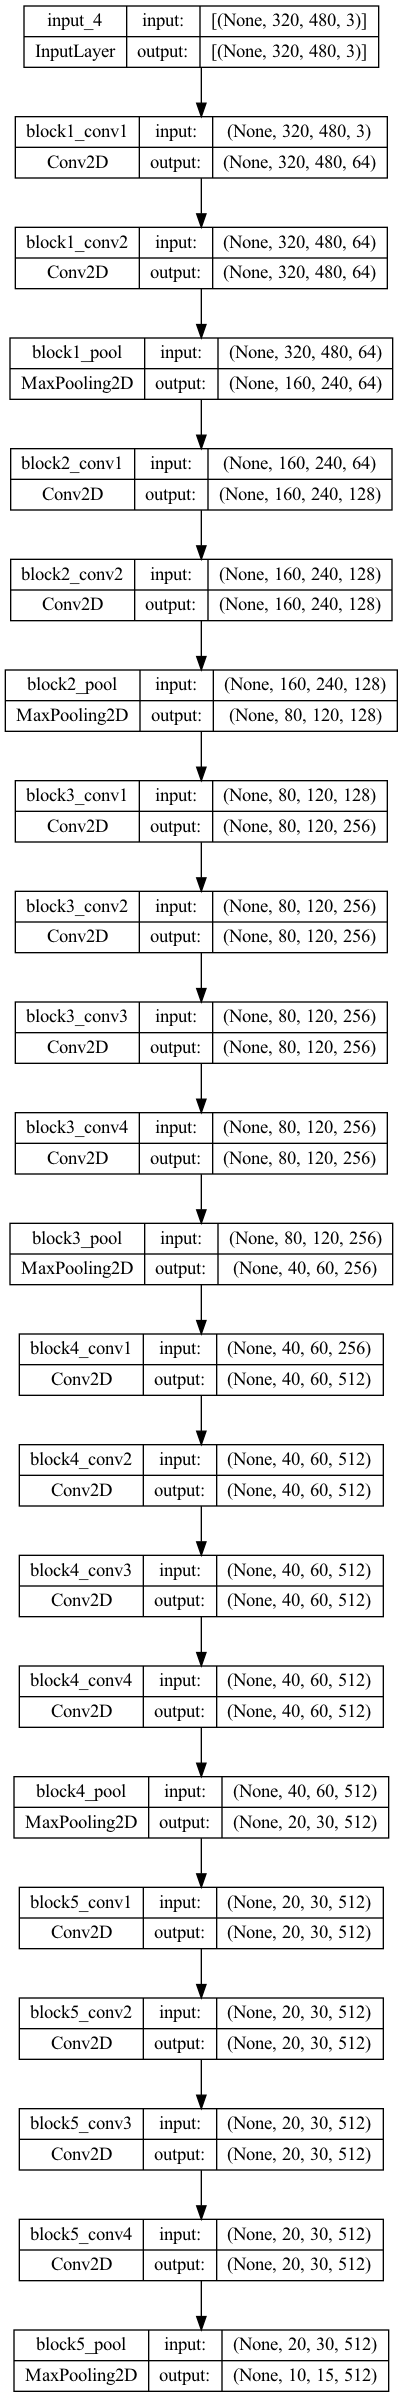

In [5]:
import tensorflow as tf
net = tf.keras.applications.VGG19(weights="imagenet",
                                                   input_shape=(320, 480, 3),
                                                   include_top=False)
from keras.utils import plot_model
plot_model(net, show_shapes=True)

In [2]:
from datasets import VocDatasets
from voc_seg_classify import VocDataGenerator, VocSegClassifyModel
import matplotlib.pyplot as plt

ds = VocDatasets()
# images, labels, seg_images = ds.load_train_dataset()

gen = VocDataGenerator(1, ds)


(160, 240, 3)
(160, 240)
[[[0.1254902  0.12941177 0.16862746]
  [0.11764706 0.13725491 0.1764706 ]
  [0.14117648 0.17254902 0.2       ]
  ...
  [0.40392157 0.48235294 0.4       ]
  [0.46666667 0.50980395 0.45882353]
  [0.5019608  0.54509807 0.49803922]]

 [[0.12156863 0.12941177 0.16078432]
  [0.11372549 0.14117648 0.16862746]
  [0.13725491 0.17254902 0.2       ]
  ...
  [0.44705883 0.5294118  0.43137255]
  [0.4509804  0.5176471  0.4392157 ]
  [0.45882353 0.53333336 0.45882353]]

 [[0.12156863 0.13333334 0.15294118]
  [0.11764706 0.14117648 0.16470589]
  [0.15686275 0.18039216 0.20784314]
  ...
  [0.4        0.4745098  0.3764706 ]
  [0.44313726 0.5019608  0.41568628]
  [0.43137255 0.49803922 0.40784314]]

 ...

 [[0.3137255  0.09019608 0.14509805]
  [0.3137255  0.08627451 0.13725491]
  [0.32941177 0.09803922 0.14509805]
  ...
  [0.5411765  0.58431375 0.6039216 ]
  [0.54901963 0.5882353  0.62352943]
  [0.5647059  0.6039216  0.6392157 ]]

 [[0.30588236 0.09411765 0.13333334]
  [0.3176470

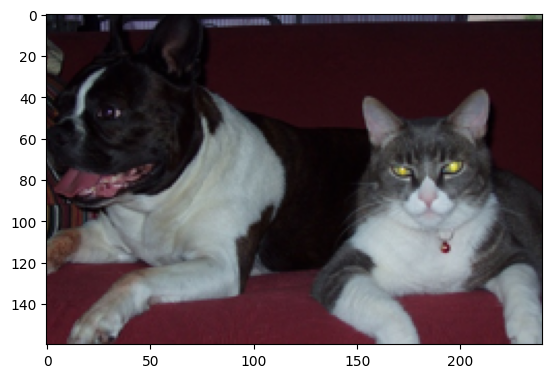

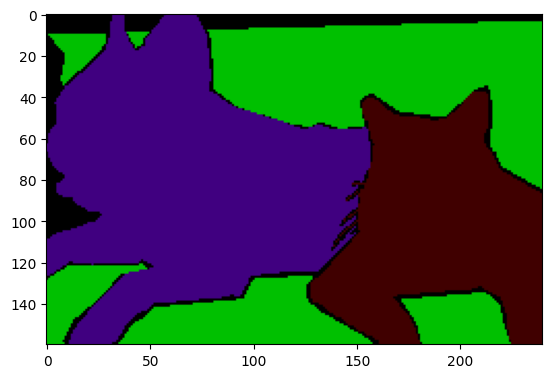

In [15]:
import matplotlib.pyplot as plt
images, labels = gen[99]
import numpy as np
image=images[0]
label=labels[0]
print(np.array(image).shape)
print(label.shape)
seg_img = ds.convert_label_to_seg_image(label)

print(image)
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(seg_img)
plt.show()